In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, BatchNormalization, Flatten, Reshape, Concatenate, GRU, LSTM, SimpleRNN , Lambda

In [2]:
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import Sequence

In [3]:
#Load dataset
gender_df = pd.read_csv("gender_train.csv")
transactions = pd.read_csv("transactions.csv").drop(["term_id","tr_datetime"],axis=1)
#Join dataset to get labels
df = transactions.merge(gender_df, how="outer",on='customer_id')

In [4]:
class DataGenerator(Sequence):
    def __init__(self, df, group_column, output_column, column_order, batch_size, k, subseq_generator_type = "rand"):
        #Paper's parameters for subseq generating
        self.k = k
        self.batch_size = batch_size
        self.subseq_generator_type = subseq_generator_type
        
        #General parameters
        self.df = df
        self.group_column = group_column
        self.column_order = column_order
        self.output_column = output_column
    
        #Get distinc id for train test val
        self.train_val_test_id_supervised()
        
        #Get dataframes for train, test val
        self.train_val_test_df_supervised()
        
        #Get self supervised data
        self.ssl_data()
        
        #Group and save data in seperate folder based on ID
        self.group_by_id_save()
        
        #Vocab_ids
        self.generate_vocab_map()
        #Set mode for data generator
        self.supervised = False
        
    def generate_vocab_map(self):
        self.vocab_map = {}
        #Iterate over categoricals and create map for value -> id
        for column in self.column_order["categoricals"]:
            cardinality = set(self.df[column])
            
            card_id = {"out":0}
            #generate val -> id
            for i, value in enumerate(cardinality):
                card_id[value] = i + 1
            self.vocab_map[column] = card_id
            
    def group_by_id_save(self):
        self.grouped_data = {}
        
        self.min_seq_len = float('inf')
        self.max_seq_len = 0
        #Group by and save data
        grouped_data = self.ssl_df.groupby(self.group_column)
        for index, df in tqdm(grouped_data, total=len(grouped_data)):
            self.grouped_data[index] = df
            self.min_seq_len = min( self.min_seq_len, df.shape[0])
            self.max_seq_len = max( self.max_seq_len, df.shape[0])
            
    def find_treshold_supervised(self):
        #Get treshold to split data into train and test for supervised learning
        self.ids_supervised = list(self.labeld_df[self.group_column].unique())
        self.treshold = int(len(self.ids_supervised) * 0.1)
        
    def train_val_test_id_supervised(self):
        #Get only labeld data
        except_id = []
        
        #for index, df_group in df.groupby(self.group_column):
            #if df_group.shape[0] < self.k:
                #except_id.append(index)
                
        self.df = self.df.loc[~self.df[self.group_column].isin(except_id)]
        
        self.labeld_df = self.df.loc[~self.df[self.output_column].isna()]
        #Get treshold for train and test 
        self.find_treshold_supervised()
        
        #Get train Ids
        self.train_id_supervised = self.ids_supervised[self.treshold:]
        
        #Split train id between train and validation
        valid_treshold = int(len(self.train_id_supervised) * 0.1)
        self.val_id_supervised = self.train_id_supervised[:valid_treshold]
        self.train_id_supervised = self.train_id_supervised[valid_treshold:]
        
        #Get test id
        self.test_id_supervised  = self.ids_supervised[:self.treshold]
    
    def ssl_data(self):
        #Skip labeld test and validation dat
        self.ssl_df = self.df.loc[~self.df[self.group_column].isin(self.val_id_supervised +  self.test_id_supervised)].drop([self.output_column],axis=1)
        #unique ids for slef supervised learning
        self.ssl_id = list(self.ssl_df[self.group_column].unique())
    
    def set_mod(self, supervised):
        #Data generation mod
        self.supervised = supervised
       
    def train_val_test_df_supervised(self):
        #Split data for supervised manner
        self.train_df_supervised = self.df.loc[self.df[self.group_column].isin(self.train_id_supervised)]
        self.val_df_supervised = self.df.loc[self.df[self.group_column].isin(self.val_id_supervised)]
        self.test_df_supervised = self.df.loc[self.df[self.group_column].isin(self.test_id_supervised)]
    
    def __len__(self):
        #Get length of iterations, based on type of task. SSL or supervised
        length = len(self.train_id_supervised) if self.supervised else len(self.ssl_id)
        length = int(np.floor(length / self.batch_size))
        return length
    
    def on_epoch_end(self):
        if self.supervised:
            np.random.shuffle(self.train_id_supervised)
        else:
            np.random.shuffle(self.ssl_id)
            
        
    def encode_pair_make_input(self, pair, max_len):
        pair_0 = []
        pair_1 = []
        
        #Iterate over categorical columns and encode
        for cat_column in self.column_order["categoricals"]:
            categorcial_encodings_0 = []
            categorcial_encodings_1 = []
            
            #Iterate over pair 0 events
            for i in range(max_len):
                encoded_0 = 0 
                encoded_1 = 0
                
                #Append value or 0 for pair 0
                if i < pair[0].shape[0]:
                    #Get value for first element of pair and encode
                    categorcial_value_0 = pair[0][cat_column].values[i]
                    encoded_0 = self.vocab_map[cat_column][categorcial_value_0]
                
                #Append value or 0 for pair 1   
                if i < pair[1].shape[0]:
                    categorcial_value_1 = pair[1][cat_column].values[i]
                    encoded_1 = self.vocab_map[cat_column][categorcial_value_1]
                    
                categorcial_encodings_0.append(encoded_0)
                categorcial_encodings_1.append(encoded_1)
            
            #Store list of encoded values of catogrical feature 
            pair_0.append(np.asarray(categorcial_encodings_0))
            pair_1.append(np.asarray(categorcial_encodings_1))
            
        #Iterate over numerical columns 
        for numerical_column in self.column_order["numericals"]:
            numerical_0 = []
            numerical_1 = []
            #Iterate over events
            for i in range(max_len):
                numerical_value_0 = 0
                numerical_value_1 = 0
                
                #Get nuemrical value for pair 0 
                if i < pair[0].shape[0]:
                    numerical_value_0 = float(pair[0][numerical_column].values[i])
                
                #Get nuemrical value for pair 1
                if i < pair[1].shape[0]:
                    numerical_value_1 = float(pair[1][numerical_column].values[i])
                
                #Store numerical value
                numerical_0.append(numerical_value_0)
                numerical_1.append(numerical_value_1)

            #Store list of numerical values of feature 
            pair_0.append(np.asarray(numerical_0))
            pair_1.append(np.asarray(numerical_1))
    
        return (pair_0, pair_1)
    
    def random_sampeling_depricated(self, index):
        #Get ids based n training type
        ids = self.train_id_supervised if self.supervised else  self.ssl_id
        #Get batch ids
        start = index * self.batch_size
        id_batch = ids[start: start + self.batch_size]
        
        sequances = []
            
        for id in id_batch:
            df = pd.read_csv(self.path + "{}.csv".format(id)).head(self.k)
            positive = random.randint(0,1)
            sequances.append((df, positive))
            
        #TODO: Create pair generation
        pairs = []
        for i, item in enumerate(sequances):
            label = item[1]
            df = item[0]
            target_df = None
                
            if label == 1:
                target_df = df
            else:
                id_seq = random.randint(0, len(sequances) - 1)
                while id_seq == i:
                    id_seq = random.randint(0, len(sequances) - 1)
                target_df = sequances[id_seq][0]
                
            pairs.append(((df[0:self.k//2], target_df[self.k//2:self.k]), label))
        #batch input
        x = []
        y = []
            
        #encode pairs
        encoded_pairs = []
        for pair in pairs:
            encoded_pairs.append(self.encode_pair_make_input(pair[0]))
            y.append(pair[1])
            
        x_0 = []
        x_1 = []
            
        for i, column_name in enumerate(self.column_order["categoricals"] + self.column_order["numericals"]):
            shape = (self.batch_size, self.k//2) if i < len(self.column_order["categoricals"]) else (self.batch_size, self.k//2, 1)
                
            input_batch_0 = np.asarray([pair[0][i] for pair in encoded_pairs]).reshape(shape)  
            input_batch_1 = np.asarray([pair[1][i] for pair in encoded_pairs]).reshape(shape)
              
                    
            x_0.append(input_batch_0)
            x_1.append(input_batch_1)
        return x_0 + x_1, np.asarray(y)
    
    def random_sampeling_new(self, index):
        #Get ids based n training type
        ids = self.train_id_supervised if self.supervised else  self.ssl_id
        #Get batch ids
        start = index * self.batch_size
        id_batch = ids[start: start + self.batch_size]
        
        sequances = []
        #Get clients dataframes and labels
        for id in id_batch:
            df = self.grouped_data[id]
            positive = random.randint(0,1)
            sequances.append((df, positive))
       
        #Generate subsequances
        max_subseq_len = 0
        subsequances_list =  []
        for sequance in sequances:
            k = 0
            sub_sequances = []
            
            df = sequance[0]
            seq_len = df.shape[0]
            
            while k != self.k:
                t_i = random.randint(self.min_seq_len, self.max_seq_len)
                if  t_i <= seq_len:
                    s = random.randint(0, seq_len - t_i)
                    sub_sequances.append(df[s: s + t_i - 1])
                    k+=1
            subsequances_list.append((sub_sequances, sequance[1]))
            
        
        pairs = []
        #generate pairs
        for i, item in enumerate(subsequances_list):
            label = item[1]
            sub_sequances = item[0]
            
            source_id = random.randint(0, len(sub_sequances) - 1)
            source_subseq = sub_sequances[source_id]
            
            target_subseq = None
                
            if label == 1:
                #Get positive subsequance not equal to source subsequance
                potivie_targe_id = 0 
                while potivie_targe_id == source_id:
                    potivie_targe_id = random.randint(0, len(sub_sequances) - 1)
                target_subseq = sub_sequances[potivie_targe_id]
            else:
                #Get negative subsequances
                id_seq = random.randint(0, len(subsequances_list) - 1)
                while id_seq == i:
                    id_seq = random.randint(0, len(subsequances_list) - 1)
                target_subsequances = subsequances_list[id_seq][0]
                target_subseq = target_subsequances[ random.randint(0, len(target_subsequances) - 1)]
            max_subseq_len = max(max_subseq_len, source_subseq.shape[0])
            max_subseq_len = max(max_subseq_len,target_subseq.shape[0])
            
            pairs.append(((source_subseq, target_subseq), label))
            
        #batch input
        x = []
        y = []
            
        #encode pairs
        encoded_pairs = []
        for pair in pairs:
            #Changed:max_subseq_len -> self.max_seq_len
            encoded_pairs.append(self.encode_pair_make_input(pair[0], self.max_seq_len))
            y.append(pair[1])
            
        x_0 = []
        x_1 = []
        
        
        #TODO: change shape part as we will send any size of sequance length
        for i, column_name in enumerate(self.column_order["categoricals"] + self.column_order["numericals"]):
            shape = (self.batch_size, self.max_seq_len) if i < len(self.column_order["categoricals"]) else (self.batch_size, self.max_seq_len, 1)
                
            input_batch_0 = np.asarray([pair[0][i] for pair in encoded_pairs]).reshape(shape)  
            input_batch_1 = np.asarray([pair[1][i] for pair in encoded_pairs]).reshape(shape)
              
                    
            x_0.append(input_batch_0)
            x_1.append(input_batch_1)
        return x_0 + x_1, np.asarray(y)
    
    def __getitem__(self, index):
        
        #if self.supervised:
         #   pass
        #else:
        return self.random_sampeling_new(index)


In [5]:
column_order = {"categoricals":["mcc_code","tr_type"],
               "numericals":["amount"]}
generator = DataGenerator(df,"customer_id","gender", column_order, 64, 5)

categorcial = {
    'mcc_code':[len(generator.vocab_map['mcc_code']),1200],
    'tr_type':[len(generator.vocab_map['tr_type']),1200]
}
numerical = ["amount"]

100%|██████████| 13404/13404 [00:00<00:00, 25477.77it/s]


In [16]:
class CoLES(object):
    def __init__(self, 
                 categorical_embeddings_info, 
                 numerical_variables_info, 
                 input_length=7,
                 rnn_type="simple",
                 rnn_units = 64,
                 **kwargs):
        super(CoLES, self).__init__(**kwargs)
        
        #For storing intermediate layers for calling from call() method
        self.inputs = {"input_0":{}, "input_1":{}}
        self.embeddings = {}
        self.batch_norms = {}
        
        #Inputs info . E.g embeddings sizes per categorcial features and names of numerical variables
        self.categorcial_embeddigs_info = categorical_embeddings_info
        self.numerical_variables = numerical_variables_info
        self.input_length = input_length
        #Add categorcial embeddings
        self.add_embeddings_batchNorm_layers(categorical=True)
        #Add numerical inputs with batch normalizations
        self.add_embeddings_batchNorm_layers(categorical=False)
        #Concat layer
        self.concat = Concatenate(axis=-1)
        #Encoder
        self.rnn = self.getRNN(rnn_type, rnn_units)
        #Distance layer
        self.l2 = Lambda(self.l2)
        self.build_model()
        
    def build_model(self):
        x = [[],[]]
        inputs = []
        
        #Evaluate inputs for input branch 1 and 2.
        #Iterate over each branch
        for i, input_path in enumerate(self.inputs.keys()):
            #Iterate over current branchs inputs to evaluate and store result
            for j, input_key in enumerate(self.inputs[input_path].keys()):
                x[i].append(self.inputs[input_path][input_key])
                inputs.append(self.inputs[input_path][input_key])
        
        #Evaluate embeddings for categorical inputs       
        for i in range(len(self.inputs)):
            #Iterate over embeddings, evaluate and store
            for j, embedding_key in enumerate(self.embeddings.keys()):
                x[i][j] = self.embeddings[embedding_key](x[i][j])
                
        #Evaluate batch normalization for numerical inputs       
        for i in range(len(self.inputs)):
            #Iterate over batch normalizations and evaluate
            for j, numerical_key in enumerate(self.batch_norms.keys()):
                #Get index for numerical as we store in list categoricals as well
                numerical_index = j + len(self.embeddings)
                x[i][numerical_index] = self.batch_norms[numerical_key](x[i][numerical_index])
        
        #Concatination of embeddings and normalized nuemricals
        concat_0 = self.concat(x[0])
        concat_1 = self.concat(x[1])
        
        #Encoders
        encoder_0 = self.rnn(concat_0)
        encoder_1 = self.rnn(concat_1)
        
        #L2 distance calculation
        l2_distance = self.l2([encoder_0, encoder_1])
        self.model = Model(inputs=inputs,outputs=l2_distance)

    #L2 distance function for lambda layer
    def l2(self, vectors):
        x, y = vectors
        return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
    
    #Returns rnn based on type
    def getRNN(self, rnn_type, units):
        if "simple" == rnn_type:
            return SimpleRNN(units)
        elif "lstm" == rnn_type:
            return LSTM(units)
        elif "gru" == rnn_type:
            return GRU(units)
        
    #Adds inputs, and based on variable type or embedding or bach normalization layer
    def add_embeddings_batchNorm_layers(self, categorical):
        #Get categorcial or numerical feature information
        feature_names = self.categorcial_embeddigs_info.keys() if categorical else self.numerical_variables
        
        #Iterate over features and create inputs for each one
        #based on feature type create embedding or batch normalization layer
        for var_name in feature_names:
            
            #Postfix of input key
            postfix = "categorcial" if categorical else "numerical"
            postfix = postfix + "_{}".format(var_name)
            
            #Name of input layer
            input_key_0 = "input_0_{}".format(postfix)
            input_key_1 = "input_1_{}".format(postfix)
            
            #Input dim based on feature type
            input_dim = self.input_length if categorical else (self.input_length, 1)
            #Inputs
            input_0 = Input(input_dim, name=input_key_0)
            input_1 = Input(input_dim, name=input_key_1)
            
            #Store inputs for calling from call() method
            self.inputs["input_0"][input_key_0] = input_0
            self.inputs["input_1"][input_key_1] = input_1
            
            #Create embedding and store
            if (categorical):
                #Embedding layer
                vocab_size = self.categorcial_embeddigs_info[var_name][0]
                embedding_dim = self.categorcial_embeddigs_info[var_name][1]
                categorcial_embedding = Embedding(vocab_size, embedding_dim, input_length = self.input_length, name="embedding_{}".format(var_name))
                self.embeddings[var_name] = categorcial_embedding
            #Create BatchNormalization layer
            else:
                #Batch normalization
                btch_norm = BatchNormalization()
                self.batch_norms[var_name] = btch_norm

In [17]:
def contrastive_loss(y, preds, margin=0.5):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [18]:
categorcial

{'mcc_code': [185, 1200], 'tr_type': [78, 1200]}

In [19]:
numerical

['amount']

In [20]:
coles = CoLES(categorcial, numerical,input_length=generator.max_seq_len)
coles.model.compile(loss=contrastive_loss, optimizer="adam", metrics=['accuracy'])

In [21]:
coles.model.input_shape

[(None, 34229),
 (None, 34229),
 (None, 34229, 1),
 (None, 34229),
 (None, 34229),
 (None, 34229, 1)]

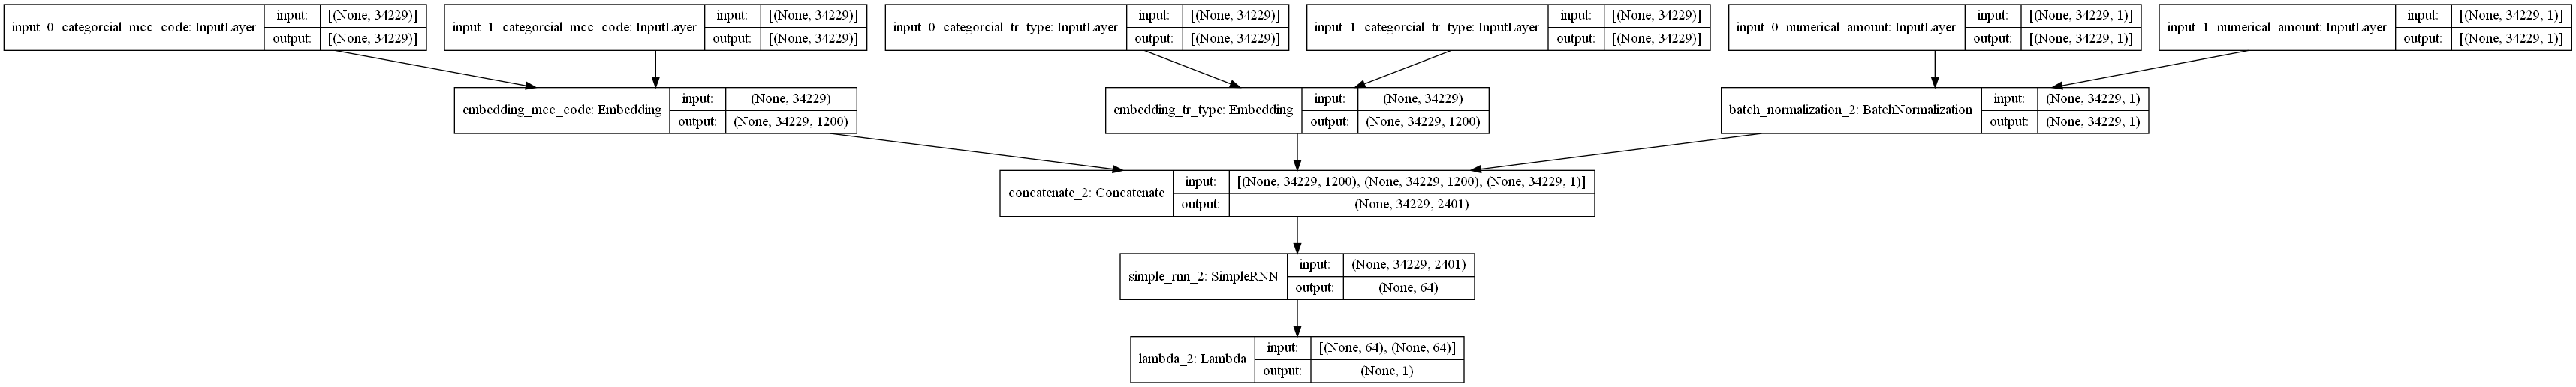

In [22]:
tf.keras.utils.plot_model(coles.model, to_file="model.png", show_shapes=True)

In [23]:
history = coles.model.fit_generator(generator, epochs=300)

C:\Users\grigor.vardanyan\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300


ResourceExhaustedError:  OOM when allocating tensor with shape[64,34229,1200] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node model_1/embedding_tr_type/embedding_lookup_1 (defined at <ipython-input-23-d3dd1f96b506>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_3386]

Errors may have originated from an input operation.
Input Source operations connected to node model_1/embedding_tr_type/embedding_lookup_1:
 model_1/embedding_tr_type/embedding_lookup/2244 (defined at C:\Users\grigor.vardanyan\Anaconda3\lib\contextlib.py:113)

Function call stack:
train_function


In [529]:
coles.model.save("coles.hdf5")

In [532]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [5]:
# Play Windows exit sound.

winsound.PlaySound("SystemExit", winsound.SND_ALIAS)

# Probably play Windows default sound, if any is registered (because
# "*" probably isn't the registered name of any sound).
winsound.PlaySound("*", winsound.SND_ALIAS)

In [6]:
import time
import winsound
i = 1
time.sleep(60)
while True:
    #Eeach up and down takes 15 second, take a res after each 40 repeats
    if i%40 == 0:
        winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
        winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
        time.sleep(560)
        winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
        time.sleep(60)
        i+=1
        winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
        continue
    #Start
    winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
    #10 Seconds
    time.sleep(10)
    #Stop
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
    #5 Seconds
    time.sleep(5)
    i+=1

KeyboardInterrupt: 

In [7]:
i

35